<a href="https://colab.research.google.com/github/TY-2009/Precision-Treatment-for-Colorectal-Cancer/blob/main/Precision_Medicine_Colorectal_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
project = "histology"

import requests
from IPython.display import Markdown, display

import tensorflow_datasets as tfds
from tensorflow.image import resize_with_pad, ResizeMethod

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def ProjectDescription(project):
  display_str =  f"**[{project.capitalize()} Project Background Document]({article_url_dict[project]})** <br />"
  display_str += f"**[{project.capitalize()} Dataset Documentation]({dataset_documentation_url_dict[project]})** <br />"
  display(Markdown(display_str))
  response = requests.get(image_url_dict[project], stream=True)
  img = Image.open(response.raw)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

def plot_metric(history, metric="accuracy", best_is_max=True, start_epoch=0, random_model_metric=None):
  # Get lists of accuracies over the epochs
  training_accuracy = history.history[metric][start_epoch:]
  validation_accuracy = history.history['val_' + metric][start_epoch:]

  # Find best epoch depending on whether max is the best for the metric
  if best_is_max:
    best_epoch = validation_accuracy.index(max(validation_accuracy))
  else:
    best_epoch = validation_accuracy.index(min(validation_accuracy))

  # Plot labels
  plt.title(metric.capitalize() + ' as Model Trains')
  plt.xlabel('Epoch #')
  plt.ylabel(metric.capitalize())

  # Plot lines
  plt.plot(training_accuracy, label='Train')
  plt.plot(validation_accuracy, label='Validation')
  plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best Epoch')

  if random_model_metric is not None:
    plt.axhline(random_model_metric, linestyle='--',color='red', label='Chance')

  # Plot legend and show
  plt.legend()
  plt.show()

# URL dictionaries for the projects
article_url_dict = {
    "histology" : "https://docs.google.com/document/d/162WhUE9KqCgq_I7-VvENZD2n1IVsbeXVRSwfJEkxAqQ/edit?usp=sharing",

}

image_url_dict = {
    "histology" : "https://storage.googleapis.com/tfds-data/visualization/fig/colorectal_histology-2.0.0.png",
}

download_url_prefix_dict = {
    "histology" : "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Towards%20Precision%20Medicine/",
}

dataset_documentation_url_dict = {
    "histology" : "https://www.tensorflow.org/datasets/catalog/colorectal_histology",
}

# Load dataset
if project == "Choose your dataset!":
  print("Please choose your dataset from the dropdown menu!")

elif project == "beans":
  data,  info = tfds.load('beans', split='train[:1024]', as_supervised=True, with_info=True)
  feature_dict = info.features['label'].names
  images = np.array([resize_with_pad(image, 128, 128, antialias=True) for image,_ in data]).astype(int)
  labels = [feature_dict[int(label)] for image,label in data]

elif project == "malaria":
  data,  info = tfds.load('malaria', split='train[:1024]', as_supervised=True, with_info=True)
  images = np.array([resize_with_pad(image, 256, 256, antialias=True) for image,_ in data]).astype(np.uint8)
  labels = ['malaria' if label==1 else 'healthy' for image,label in data]

else:
  wget_command = f'wget -q --show-progress "{download_url_prefix_dict[project]}'
  !{wget_command + 'images.npy" '}
  !{wget_command + 'labels.npy" '}

  images = np.load('images.npy')
  labels = np.load('labels.npy')

  !rm images.npy labels.npy


# Original preprocessing code for datasets

# if project == "histology":
#   data,  info = tfds.load('colorectal_histology', split='train[:1024]', as_supervised=True, with_info=True)
#   feature_dict = info.features['label'].names
#   images = np.array([image for image,label in data]).astype(int)
#   labels = [feature_dict[int(label)] for image,label in data]

# if project == "bees":
#   data,  info = tfds.load('bee_dataset', split='train[:3200]', as_supervised=True, with_info=True)
#   data = [(image, label) for image,label in data if label['wasps_output']==0]
#   data1 = [(image, label) for image,label in data if label['varroa_output']==0][:500]
#   data2 = [(image, label) for image,label in data if label['varroa_output']==1][:500]
#   data = data1 + data2
#   images = np.array([image for image, _ in data]).astype(int)
#   labels = ['diseased' if label['varroa_output'] else 'healthy' for image,label in data]

images.npy          100%[===================>] 527.34M  15.4MB/s    in 7.2s    
labels.npy          100%[===================>]  28.12K  --.-KB/s    in 0s      


In [3]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv3D, Flatten

labels_ohe = np.array(pd.get_dummies(labels))

y = labels_ohe
X = images


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

cnn_model = Sequential()

cnn_model.add(Input(shape=X_train.shape[1:]))

# First layer
cnn_model.add(Conv2D(8, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))

# Second layer
cnn_model.add(Conv2D(16, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))

# Third layer
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))

# # Fourth layer
cnn_model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
cnn_model.add(MaxPooling2D((2, 2)))


# Flattening layer
cnn_model.add(Flatten())

# Hidden (dense) layer with 32 nodes, and relu activation function.
cnn_model.add(Dense(32, activation='relu'))

# Final output layer that uses a softmax activation function.
cnn_model.add(Dense(len(set(labels)), activation='softmax'))

# Compile your model
metrics_to_track = ['categorical_crossentropy', 'accuracy']
cnn_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=metrics_to_track)

In [4]:
print('Dim X_train:', X_train.shape)
print('Dim y_train:', y_train.shape)
print('Dim X_test:', X_test.shape)
print('Dim y_test:', y_test.shape)

Dim X_train: (819, 150, 150, 3)
Dim y_train: (819, 8)
Dim X_test: (205, 150, 150, 3)
Dim y_test: (205, 8)


X_train


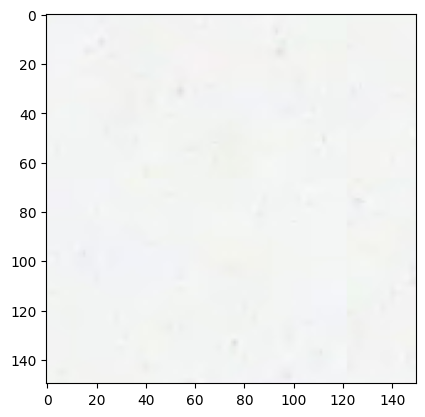

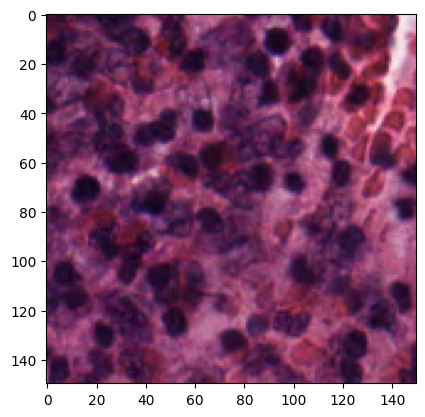

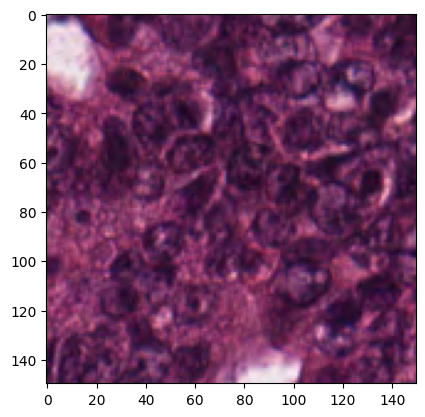

X_test


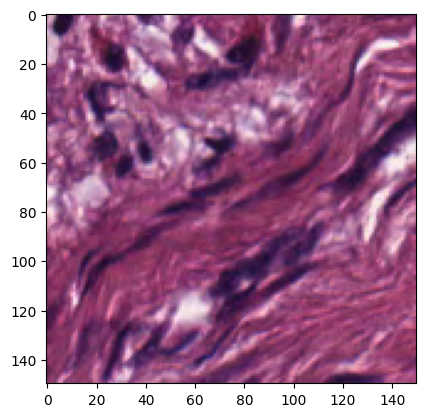

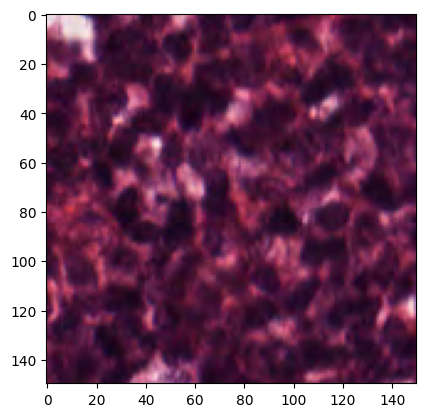

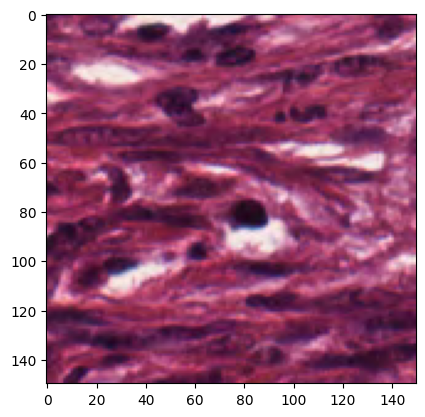

In [5]:
print("X_train")
for i in range(3):
  plt.imshow(X_train[i])
  plt.show()


print("X_test")
for i in range(3):
  plt.imshow(X_test[i])
  plt.show()

In [6]:
one_hot_encoding_to_label_dict = {np.argmax(ohe):label for ohe, label in zip(labels_ohe, labels)}

def ScoreVectorToPredictions(prob_vector):
  class_num = np.argmax(prob_vector)
  class_name = one_hot_encoding_to_label_dict[class_num]
  return class_name

print("y train")
for i in range(3):
  print(ScoreVectorToPredictions(y_train[i]))

print("y test")
for i in range(3):
  print(ScoreVectorToPredictions(y_test[i]))

y train
empty
complex
tumor
y test
complex
lympho
complex


In [7]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         165,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,712 (744.97 KB)

 Trainable params: 190,712 (744.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.1802 - categorical_crossentropy: 36.4508 - loss: 36.4508 - val_accuracy: 0.3122 - val_categorical_crossentropy: 2.0065 - val_loss: 2.0065
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3446 - categorical_crossentropy: 1.8885 - loss: 1.8885 - val_accuracy: 0.3659 - val_categorical_crossentropy: 1.7774 - val_loss: 1.7774
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3414 - categorical_crossentropy: 1.9746 - loss: 1.9746 - val_accuracy: 0.3707 - val_categorical_crossentropy: 1.7265 - val_loss: 1.7265
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3414 - categorical_crossentropy: 1.9711 - loss: 1.9711 - val_accuracy: 0.3707 - val_categorical_crossentropy: 2.3527 - val_loss: 2.3527
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4306 - categorical_crossentropy: 1.5617 - loss: 1.5617 - val_accuracy: 0.3854 - val_categorical_crossentropy: 1.4653 - val_loss:

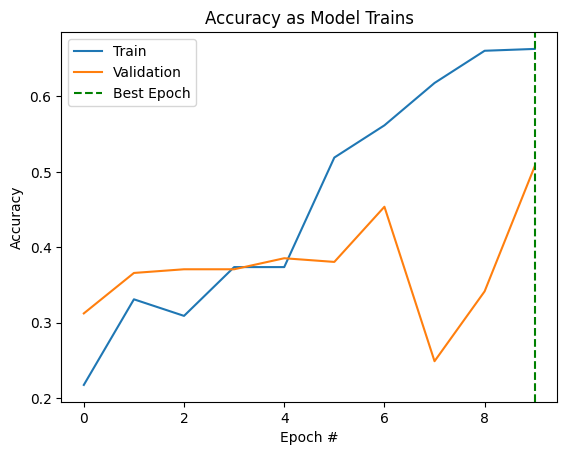

In [8]:
history = cnn_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test), epochs=10)
plot_metric(history)

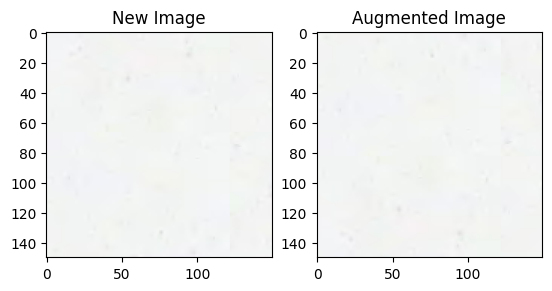

In [9]:
from numpy import flipud

def createAugmentedImage(original_image):
  new_image = flipud(original_image)
  return new_image

new_image = createAugmentedImage(X_train[0])

f, ax = plt.subplots(ncols=2)
ax[0].imshow(X_train[0])
ax[0].set_title('New Image')
ax[1].imshow(new_image)
ax[1].set_title('Augmented Image')
plt.show()

In [10]:
for i in range(100):
  new_X = createAugmentedImage(X_train[i])
  new_y = y_train[i]

  if i == 0:
    X_train_augment = [new_X]
    y_train_augment = [new_y]
  else:
    X_train_augment = np.append(X_train_augment, [new_X], axis=0)
    y_train_augment = np.append(y_train_augment, [new_y], axis=0)


print("Dimensions of augmented X:", X_train_augment.shape)
print("Dimensions of y:", y_train_augment.shape)

Dimensions of augmented X: (100, 150, 150, 3)
Dimensions of y: (100, 8)


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.4673 - categorical_crossentropy: 1.7131 - loss: 1.7131 - val_accuracy: 0.3707 - val_categorical_crossentropy: 1.5702 - val_loss: 1.5702
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4137 - categorical_crossentropy: 1.3980 - loss: 1.3980 - val_accuracy: 0.4000 - val_categorical_crossentropy: 1.5372 - val_loss: 1.5372
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5940 - categorical_crossentropy: 0.9770 - loss: 0.9770 - val_accuracy: 0.3854 - val_categorical_crossentropy: 2.3670 - val_loss: 2.3670
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4420 - categorical_crossentropy: 1.3160 - loss: 1.3160 - val_accuracy: 0.3415 - val_categorical_crossentropy: 1.5886 - val_loss: 1.5886
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7090 - categorical_crossentropy: 0.6601 - loss: 0.6601 - val_accuracy: 0.3366 - val_categorical_crossentropy: 2.3377 - val_loss: 2.3377


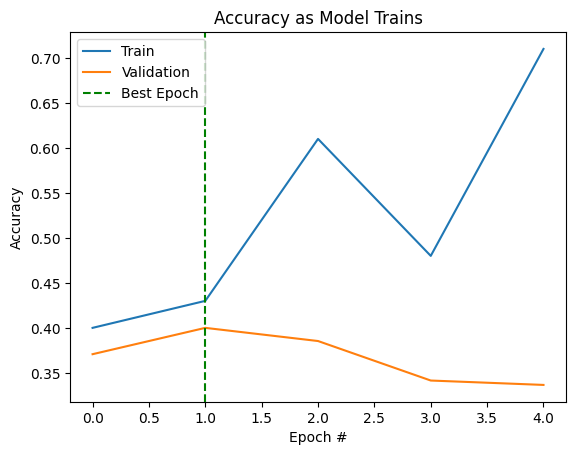

In [11]:
additional_history = cnn_model.fit(X_train_augment, y_train_augment, validation_data=(X_test, y_test), epochs=5)
plot_metric(additional_history)

In [12]:
from keras.applications import MobileNetV2, VGG16
mobile_net = VGG16(include_top=True)
mobile_net.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

from keras import Model

new_output_layer = Dense(len(y_train[0]), activation='softmax')


output = new_output_layer(mobile_net.layers[-2].output)
input = mobile_net.input
transfer_cnn = Model(input, output)


transfer_cnn.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,293,320 (512.29 MB)

 Trainable params: 134,293,320 (512.29 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

for layer in transfer_cnn.layers:
    layer.trainable = False

transfer_cnn.layers[-1].trainable = True


transfer_cnn.compile(loss='categorical_crossentropy', optimizer='adam',
                     metrics=['accuracy', 'categorical_crossentropy'])

transfer_cnn.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,293,320 (512.29 MB)

 Trainable params: 32,776 (128.03 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [15]:
def ResizeImages(images, height, width):
  return np.array([resize_with_pad(image, height, width, antialias=True) for image in images]).astype(int)

X_train_resized = ResizeImages(X_train, 224, 224)
X_test_resized = ResizeImages(X_test, 224, 224)

print("Dim X_train_resized:", X_train_resized.shape)
print("Dim X_test_resized:", X_test_resized.shape)

Dim X_train_resized: (819, 224, 224, 3)
Dim X_test_resized: (205, 224, 224, 3)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 977ms/step - accuracy: 0.4738 - categorical_crossentropy: 1.6619 - loss: 1.6619 - val_accuracy: 0.7512 - val_categorical_crossentropy: 0.6705 - val_loss: 0.6705
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.8181 - categorical_crossentropy: 0.4914 - loss: 0.4914 - val_accuracy: 0.7610 - val_categorical_crossentropy: 0.5768 - val_loss: 0.5768
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.9146 - categorical_crossentropy: 0.2324 - loss: 0.2324 - val_accuracy: 0.8293 - val_categorical_crossentropy: 0.4485 - val_loss: 0.4485
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.9415 - categorical_crossentropy: 0.1797 - loss: 0.1797 - val_accuracy: 0.8293 - val_categorical_crossentropy: 0.4352 - val_loss: 0.4352
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.9567 - categorical_crossentropy: 0.1530 - loss: 0.1530 - val_accuracy: 0.8146 - val_categorical_crossentropy: 0.5752 - val_

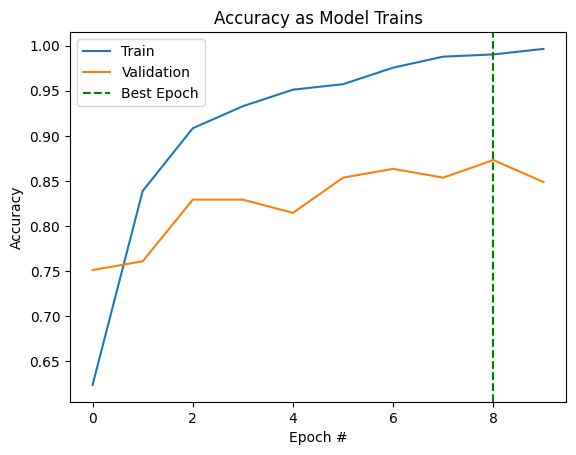

In [16]:
transfer_history = transfer_cnn.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=10)
plot_metric(transfer_history)